In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reload utils
import json
import importlib
from train_landsat_unet import * #load dataset and model classes

import utils
importlib.reload(utils)

import evaluation as eval
importlib.reload(eval)

base_path = '../data/'

/Users/conorosullivan/opt/miniconda3/envs/pytorch/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
# Load test images
test_path = base_path + 'test/'
test_paths = glob.glob(test_path + '*.npy')
print(len(test_paths))

test_mask = []
test_edge = []
test_cloud_mask = []

for path in test_paths:
    test = np.load(path)

    test_mask.append(test[:,:,-2])
    test_edge.append(test[:,:,-1])

    QA = test[:,:,7]
    cloud_mask = np.vectorize(utils.get_cloud_mask)(QA,type='cloud')
    test_cloud_mask.append(cloud_mask)

100


In [7]:
# Load predictions
final_preds = json.load(open('../data/predictions.json'))
methods = ['NDWI','Canny','XGBoost','UNET','ATTUNET','R2UNET']

for method in methods:
    preds = final_preds[method]

    preds = [np.array(arr) for arr in preds]

    final_preds[method] = preds

print(final_preds.keys())

dict_keys(['NDWI', 'Canny', 'XGBoost', 'UNET', 'ATTUNET', 'R2UNET'])


In [8]:
def get_cloud_free_pixels(masks,preds,cloud_masks):
    """Return the number of cloud free pixels in the mask"""
    cloud_free_masks = []
    cloud_free_preds = []
    for i in range(len(masks)):
        cloud_mask = cloud_masks[i]

        # Make mask np.nan where there are clouds
        mask = masks[i]
        mask = mask.astype('float16')
        mask[cloud_mask==0] = np.nan

        pred = preds[i]
        pred = pred.astype('float16')
        pred[cloud_mask==0] = np.nan
        
        cloud_free_masks.append(mask)
        cloud_free_preds.append(pred)

    
    return cloud_free_masks,cloud_free_preds

In [9]:
arr_metrics = [] #metrics for each model
arr_coast_metrics = [] #within 10 pixels
arr_cloud_metrics = [] #cloud free
methods = ['NDWI','Canny','XGBoost','UNET','ATTUNET','R2UNET']

for i,method in enumerate(methods):
    preds = final_preds[method]
    metrics, arr = eval.eval_metrics(test_mask,preds)
    metrics['method'] = method

    # Get pixels close to the coast
    coast_target,coast_preds = eval.get_coastline_pixels(test_mask,preds)
    coast_metrics, coast_arr = eval.eval_metrics(coast_target,coast_preds)
    coast_metrics['method'] = method

    # Get pixels without clouds
    cloud_target,cloud_preds = get_cloud_free_pixels(test_mask,preds,test_cloud_mask)
    cloud_metrics, cloud_arr = eval.eval_metrics(cloud_target,cloud_preds)
    cloud_metrics['method'] = method

    if method == 'Canny':
        for m in ['accuracy','balanced_accuracy','precision','recall','f1']:
            metrics[m] = 0
            coast_metrics[m] = 0
            cloud_metrics[m] = 0

    arr_metrics.append(metrics)
    arr_coast_metrics.append(coast_metrics)
    arr_cloud_metrics.append(cloud_metrics)

df_metrics = pd.DataFrame(arr_metrics,columns=['method','accuracy','balanced_accuracy','precision','recall','f1','mse','fom'])
df_cmetrics = pd.DataFrame(arr_coast_metrics,columns=['method','accuracy','balanced_accuracy','precision','recall','f1','mse','fom'])
df_cloud_metrics = pd.DataFrame(arr_cloud_metrics,columns=['method','accuracy','balanced_accuracy','precision','recall','f1','mse','fom'])

/Users/conorosullivan/Documents/git/COASTAL MONITORING/landsat-coastline-segmentation/src/evaluation.py:93: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP_/(TP_+FP_)
/Users/conorosullivan/Documents/git/COASTAL MONITORING/landsat-coastline-segmentation/src/evaluation.py:95: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2*(precision*recall)/(precision+recall)


# Summary of metrics

In [121]:
# Evaluation metrics
df_metrics = round(df_metrics,3)
df_metrics.columns = ['Method','Accuracy','Balanced Accuracy','Precision','Recall','F1','MSE','FOM']
incl = ['Method','Accuracy','Precision','Recall','F1','MSE','FOM']
df_metrics[incl].to_clipboard(index=False)
df_metrics.head(6)

Method  Accuracy  Balanced Accuracy  Precision  Recall     F1    MSE  \
0     NDWI     0.972              0.971      0.994   0.946  0.967  0.038   
1    Canny     0.000              0.000      0.000   0.000  0.000  0.029   
2  XGBoost     0.927              0.922      0.945   0.880  0.897  0.085   
3     UNET     0.966              0.966      0.963   0.960  0.959  0.031   
4  ATTUNET     0.964              0.967      0.944   0.973  0.956  0.029   
5   R2UNET     0.907              0.910      0.902   0.912  0.899  0.046   

     FOM  
0  0.718  
1  0.695  
2  0.483  
3  0.607  
4  0.591  
5  0.340

In [28]:
# Evaluation metrics within 10 pixels of coastline
df_cmetrics = round(df_cmetrics,3)
df_cmetrics.columns = ['Method','Accuracy','Balanced Accuracy','Precision','Recall','F1','MSE','FOM']
incl = ['Method','Accuracy','Precision','Recall','F1']
df_cmetrics[incl].to_clipboard(index=False)
df_cmetrics.head(6)

Method  Accuracy  Balanced Accuracy  Precision  Recall     F1    MSE  \
0     NDWI     0.938              0.938      0.983   0.891  0.927  0.021   
1    Canny     0.000              0.000      0.000   0.000  0.000  0.027   
2  XGBoost     0.845              0.849      0.875   0.816  0.825  0.041   
3     UNET     0.877              0.878      0.888   0.877  0.873  0.030   
4  ATTUNET     0.866              0.865      0.863   0.897  0.872  0.028   
5   R2UNET     0.700              0.697      0.829   0.588  0.619  0.035   

     FOM  
0  0.852  
1  0.728  
2  0.705  
3  0.614  
4  0.596  
5  0.407

In [94]:
# Evaluation metrics with cloud free pixels
df_cloud_metrics = round(df_cloud_metrics,3)
df_cloud_metrics.columns = ['Method','Accuracy','Balanced Accuracy','Precision','Recall','F1','MSE','FOM']
incl = ['Method','Accuracy','Precision','Recall','F1']
df_cloud_metrics[incl].to_clipboard(index=False)
df_cloud_metrics[incl].head(6)

Method  Accuracy  Precision  Recall     F1
0     NDWI     0.978      0.994   0.958  0.974
1    Canny     0.000      0.000   0.000  0.000
2  XGBoost     0.930      0.949   0.882  0.900
3     UNET     0.967      0.967   0.961  0.961
4  ATTUNET     0.965      0.945   0.974  0.958
5   R2UNET     0.908      0.905   0.913  0.901

# Display predictions

In [109]:
def calc_accuracy(mask,pred):
    mask = np.array(mask)
    pred = np.array(pred)

    mask = mask.flatten()
    pred = pred.flatten()

    acc = np.sum(mask == pred) / len(mask)

    return acc

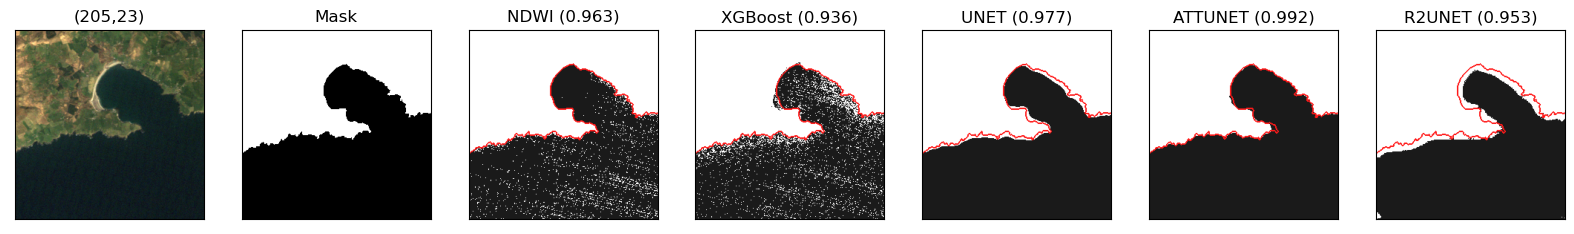

In [113]:


def plot_predicted_masks(i,methods = ['NDWI','XGBoost','UNET','ATTUNET','R2UNET'],tile=None):

    path = test_paths[i]
    test = np.load(path)
    rgb = utils.rgb_from_stack(test)

    mask = test[:,:,-2]
    edge = utils.edge_from_mask(mask)

    #only show edge in pixel value is 1
    edge = edge.astype(np.float64)
    edge[edge==0] = np.nan

    # make edge 3D
    edge = np.repeat(edge[:,:,np.newaxis],3,axis=2)

    fig,ax = plt.subplots(1,2+len(methods),figsize=(20,5))

    ax[0].imshow(rgb)
    path = tile.split('_')[0]
    row = tile.split('_')[1]
    ax[0].title.set_text(f"({path},{row})")

    ax[1].imshow(1-mask,cmap='gray')
    ax[1].set_title("Mask")

    for j, method in enumerate(methods):
        edge_j = edge.copy()

        pred = final_preds[method][i]
        accuracy = calc_accuracy(mask,pred)

        pred = 1-pred
        pred = pred.astype(np.float64)
        pred = np.repeat(pred[:,:,np.newaxis],3,axis=2)

        pred = np.where(np.isnan(edge_j),pred,[1,0,0])
    
        ax[j+2].imshow(pred,alpha=0.9)

        accuracy = round(accuracy,3)
        ax[j+2].set_title(f"{method} ({accuracy})")

    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
    return fig

fig = plot_predicted_masks(0,methods = ['NDWI','XGBoost','UNET','ATTUNET','R2UNET'],tile="205_23")

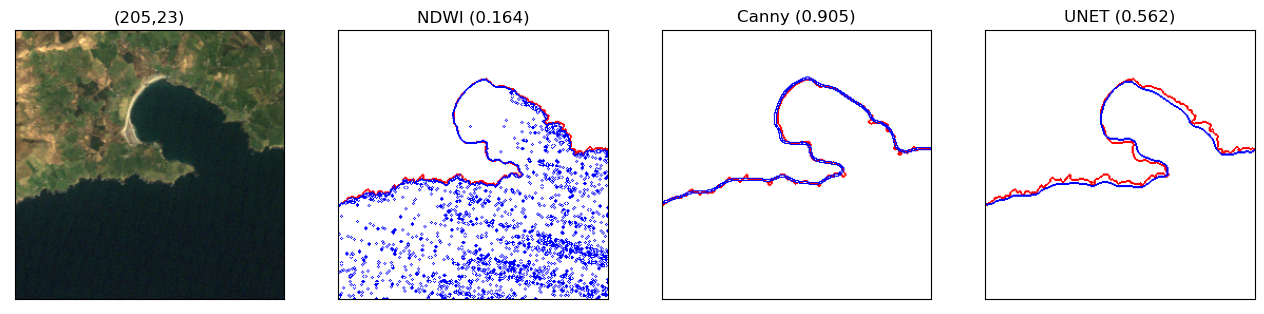

In [117]:
def plot_predicted_edge(i,methods = ['NDWI','Canny','UNET'],tile=None):
    
    path = test_paths[i]
    test = np.load(path)
    rgb = utils.rgb_from_stack(test)

    mask = test[:,:,-2]
    test_edge = utils.edge_from_mask(mask)

    #only show edge in pixel value is 1
    edge = test_edge.astype(np.float64)
    edge[edge==0] = np.nan

    # make edge 3D
    zeros = np.zeros((edge.shape[0],edge.shape[1],3))
    zeros = 1 + zeros
    edge = np.repeat(edge[:,:,np.newaxis],3,axis=2)
    edge_mask = np.where(np.isnan(edge),zeros,[1,0,0])

    fig,ax = plt.subplots(1,4,figsize=(16,5))

    ax[0].imshow(rgb)
    path = tile.split('_')[0]
    row = tile.split('_')[1]
    ax[0].title.set_text(f"({path},{row})")

    methods = ['NDWI','Canny','UNET']

    for j, method in enumerate(methods):

        edge_mask_j = edge_mask.copy()
        
        colour = [1,0,1] #purple
        if method == 'Canny':
            colour = [0,1,0] #green
        elif method == 'UNET':
            colour = [0,0,1] #blue

        mask = final_preds[method][i]

        edge = utils.edge_from_mask(mask)

        fom = eval.calc_fom(test_edge,edge)

        edge = edge.astype(np.float64)
        edge[edge==0] = np.nan
        edge = np.repeat(edge[:,:,np.newaxis],3,axis=2)

        #add alpha channel
        edge_mask_j = np.where(np.isnan(edge),edge_mask_j,[0,0,1])

        ax[j+1].imshow(edge_mask_j)
        fom = round(fom,3)
        ax[j+1].set_title(f"{method} ({fom})")

    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
    
    return fig

fig = plot_predicted_edge(0,methods = ['NDWI','Canny','UNET'],tile="205_23")

In [30]:
df_labels = pd.read_csv(base_path + 'label_scenes.csv')

In [19]:
df_labels.head()
df_labels.columns = ['year', 'altitude_category', 'id', 'path', 'row', 'satellite',
       'cloud_cover', 'tier', 'utm_zone', 'lat', 'lon', 'date', 'time',
       'month', 'altitude', 'tile']

df_labels.head()

year altitude_category                                        id  path  \
0  2017              high  LC08_L2SP_205023_20170505_20200904_02_T1   205   
1  2019              high  LC08_L2SP_205023_20190628_20200827_02_T1   205   
2  2020              high  LC08_L2SP_205023_20200529_20200820_02_T1   205   
3  2015               low  LC08_L2SP_205024_20150124_20200910_02_T1   205   
4  2015              high  LC08_L2SP_205024_20150719_20200909_02_T1   205   

   row  satellite  cloud_cover  tier  utm_zone       lat      lon        date  \
0   23          8            2     1        30  53.10266 -5.02235  2017-05-05   
1   23          8            9     1        30  53.10258 -5.04996  2019-06-28   
2   23          8            2     1        30  53.10270 -5.03278  2020-05-29   
3   24          8            4     1        30  51.69320 -5.72348  2015-01-24   
4   24          8            5     1        30  51.69345 -5.70362  2015-07-19   

                         time  month   altitude    tile  
0  2017-05-05 11:15:45.516137      5  51.383728  205_23  
1  2019-06-28 11:16:20.726652      6  57.582579  205_23  
2  2020-05-29 11:15:55.184734      5  56.487645  205_23  
3  2015-01-24 11:16:47.907172      1  17.108840  205_24  
4  2015-07-19 11:16:25.474865      7  56.077386  205_24

In [16]:
# create lists of ids for all unique tile values
def get_grouped_ids(df,cat='tile'):
    unique_cat = df[cat].unique()
    ids = {}

    for c in unique_cat:
        ids[c] = df_labels[df_labels[cat] == c]['id'].values

    return ids

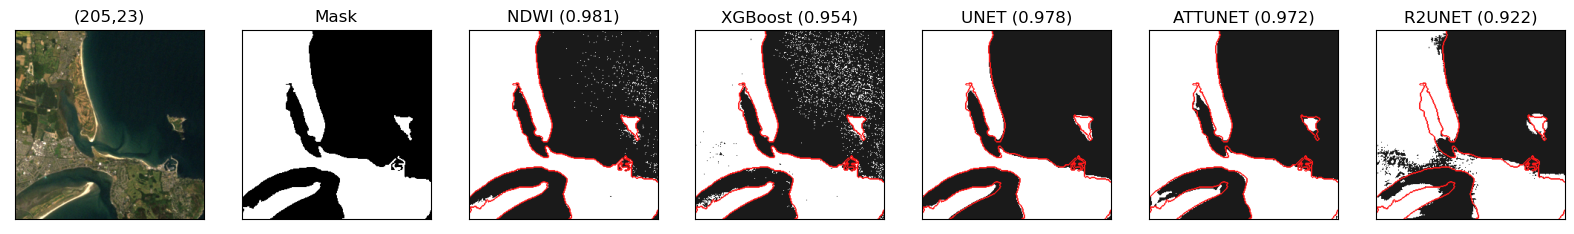

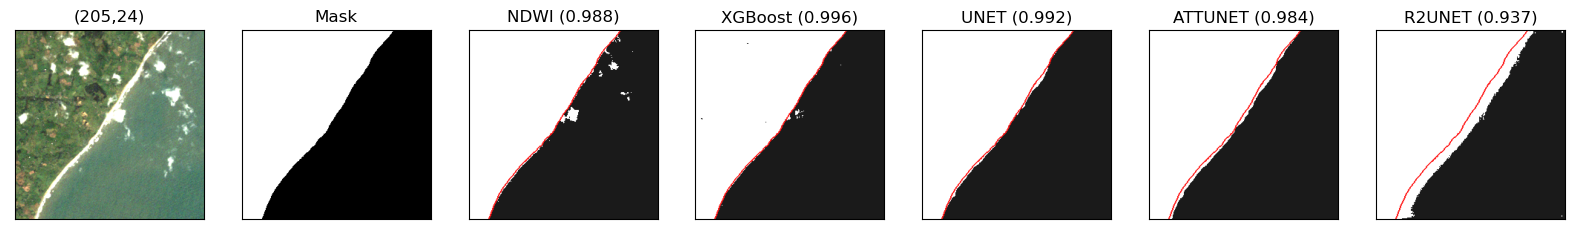

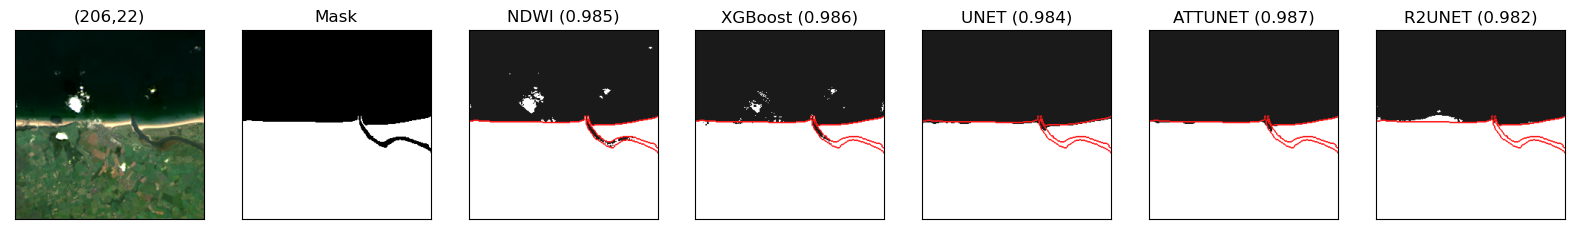

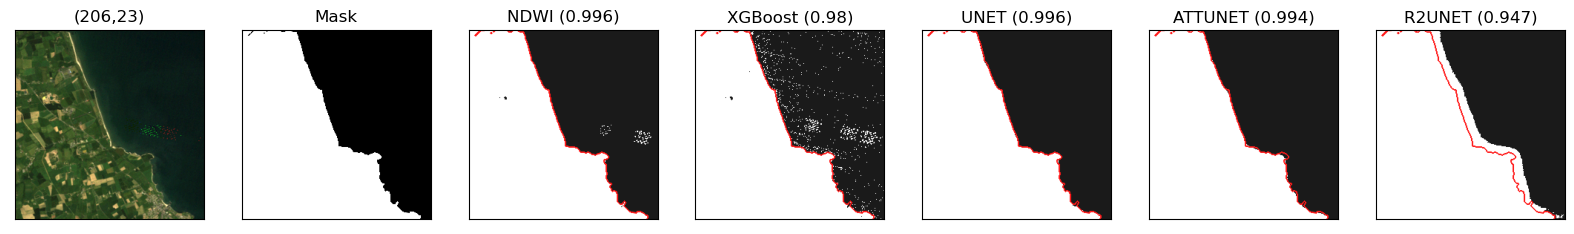

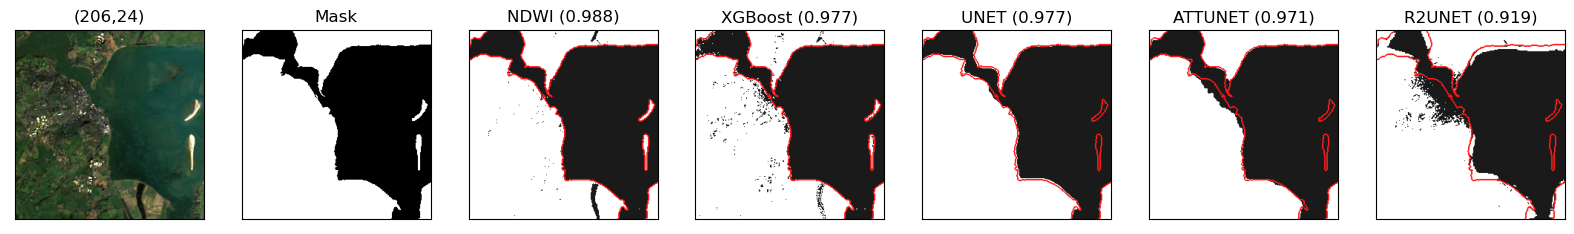

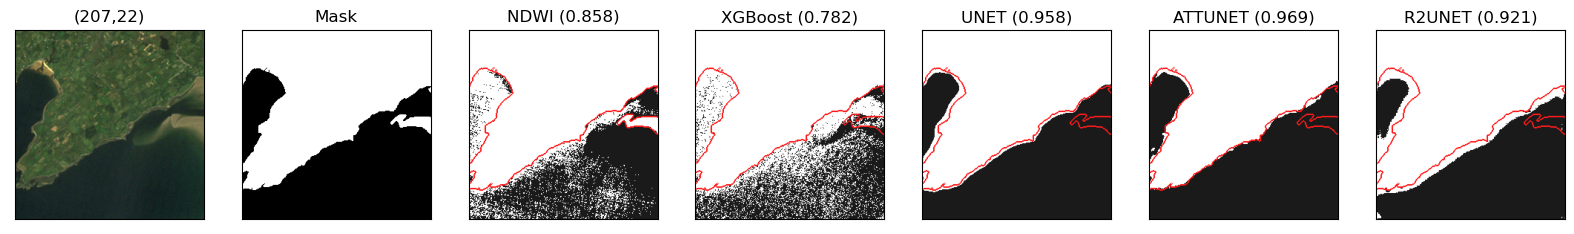

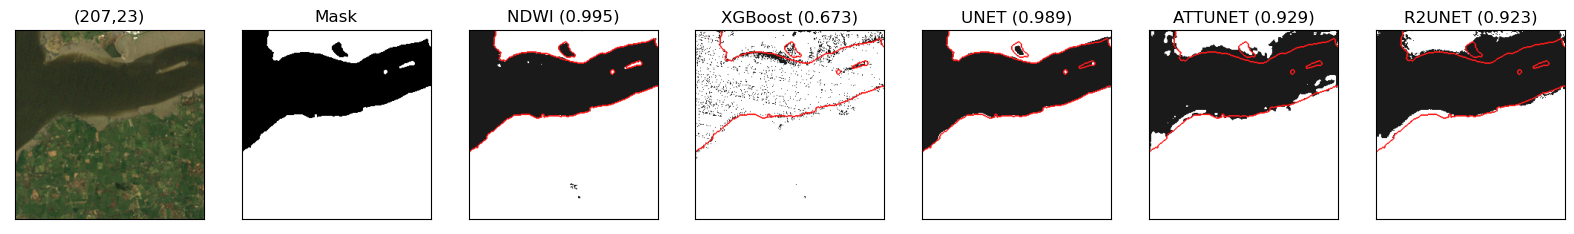

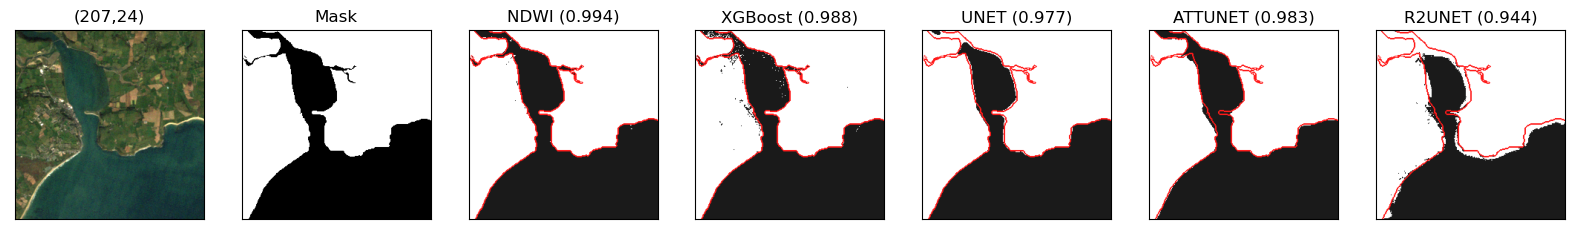

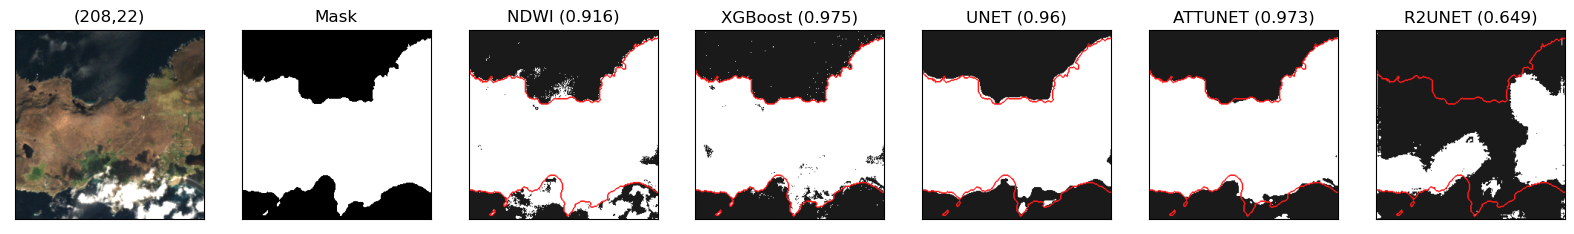

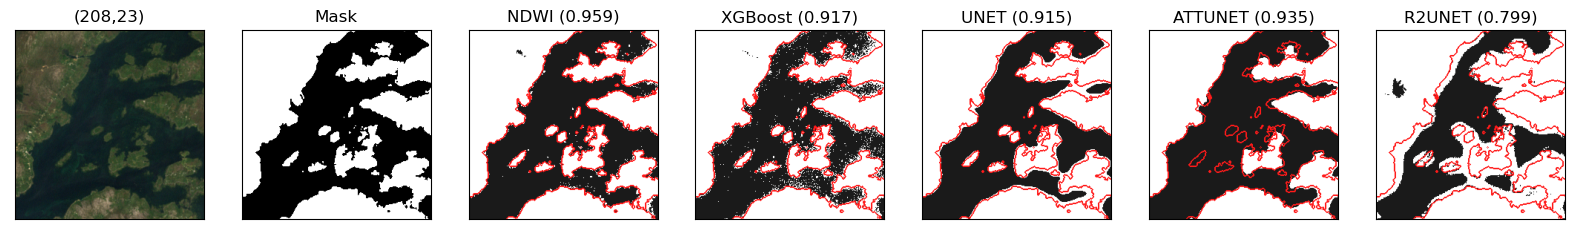

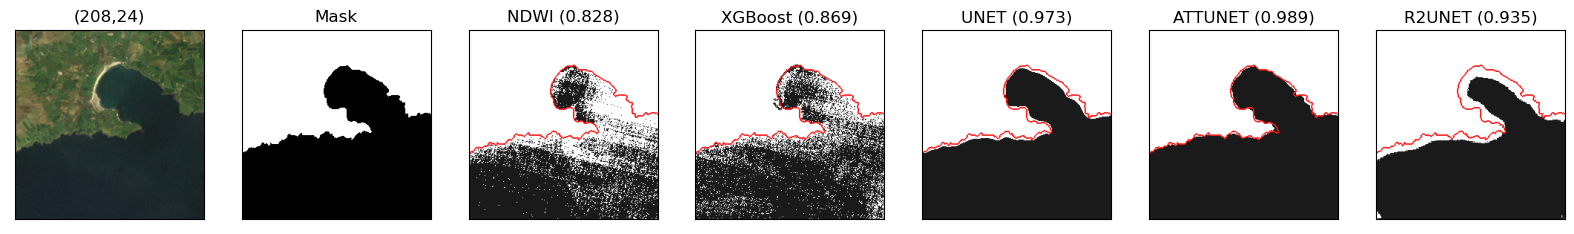

In [116]:
tile_ids = get_grouped_ids(df_labels,cat='tile')

tiles = ['205_23','205_24','206_22','206_23','206_24','207_22','207_23','207_24','208_22','208_23','208_24']

chosen_ids = []
for tile in tiles:
    ids = tile_ids[tile]
    id = random.choice(ids)
    chosen_ids.append(id)

for id,tile in zip(chosen_ids, tiles):
    i = test_paths.index(test_path + id + '.npy')
    fig = plot_predicted_masks(i,methods = ['NDWI','XGBoost','UNET','ATTUNET','R2UNET'],tile=tile)
    utils.save_fig(fig,f'{tile}_masks')

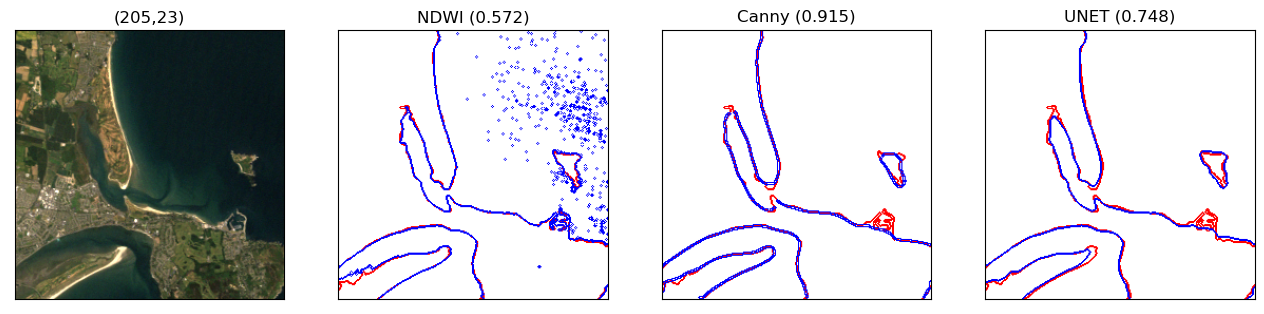

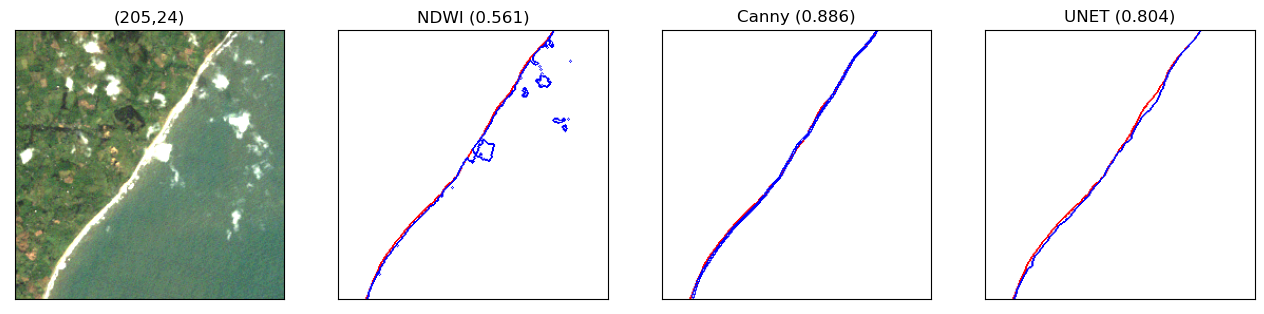

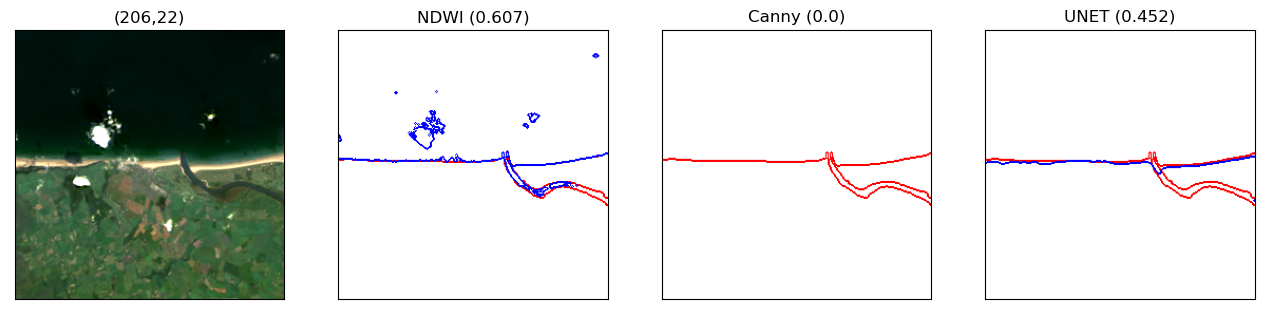

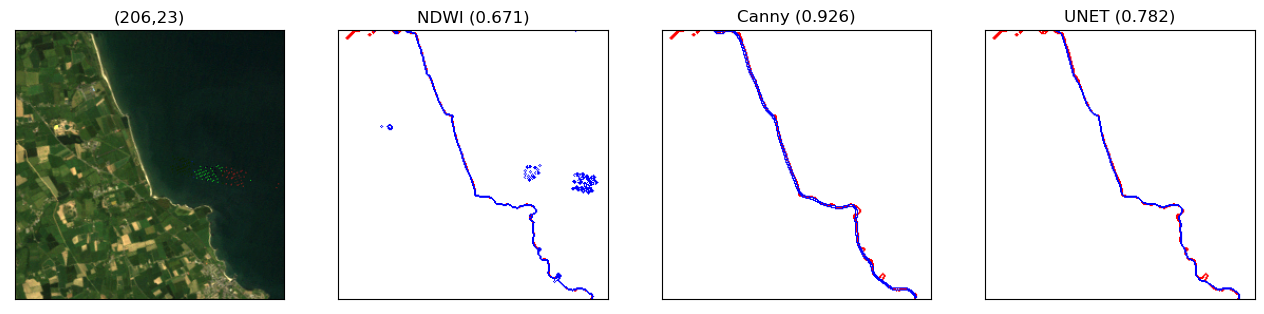

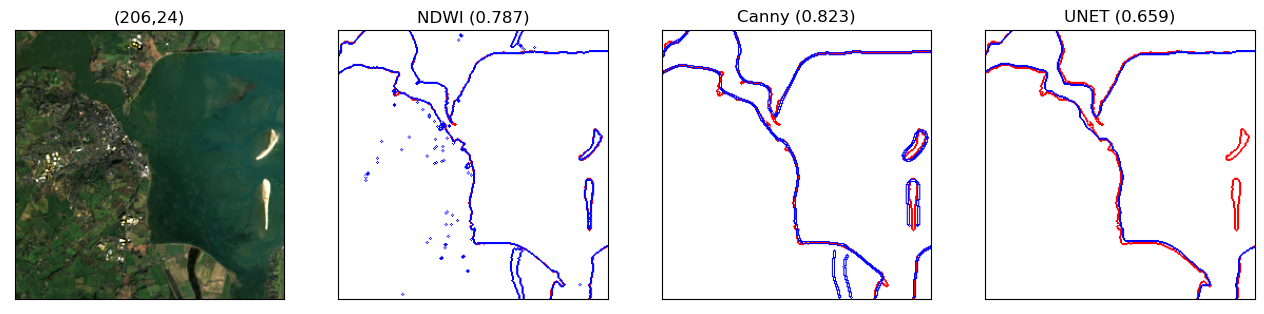

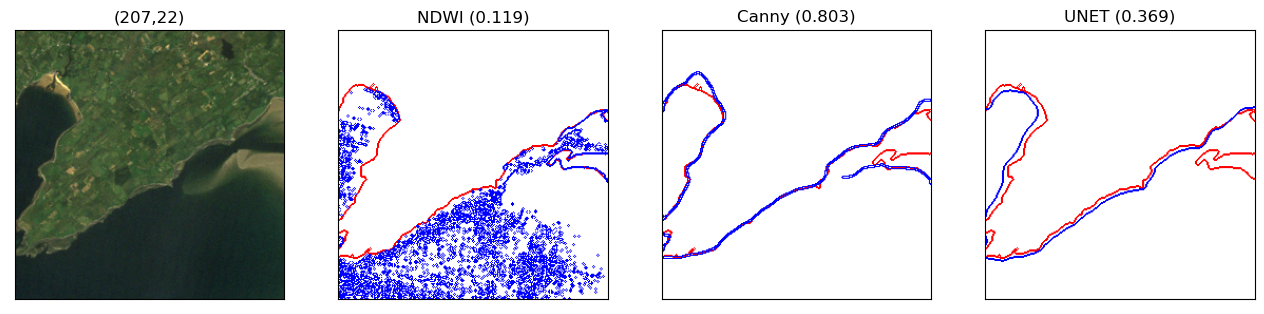

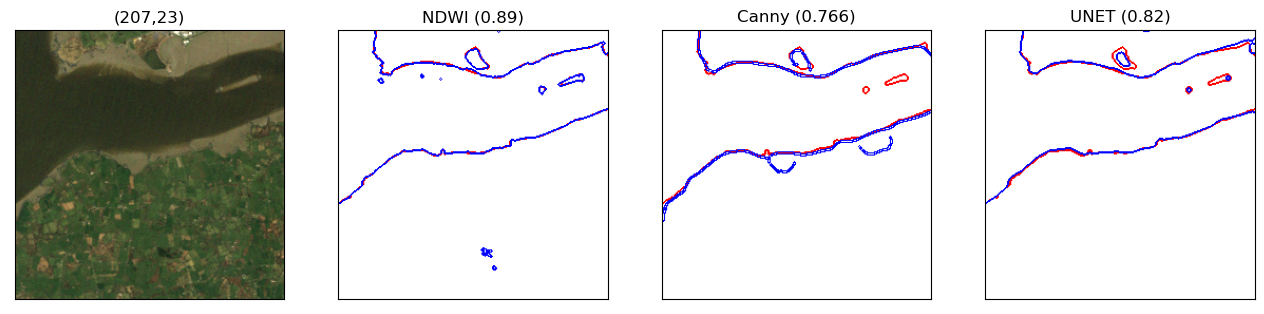

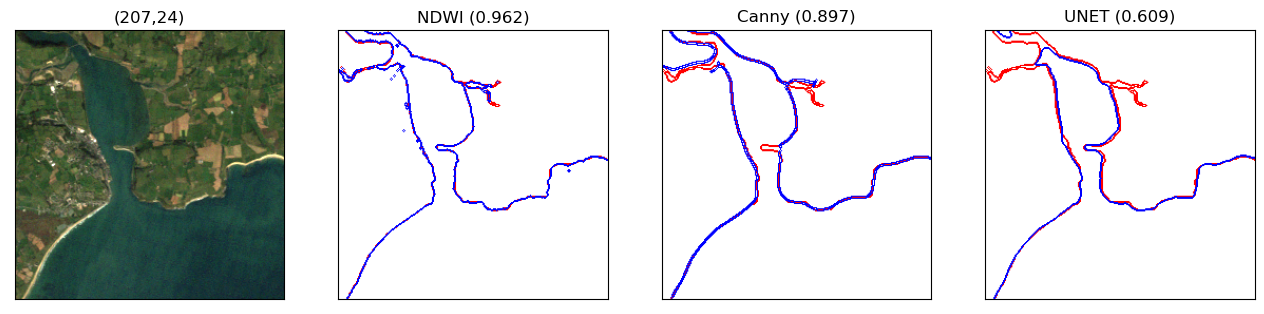

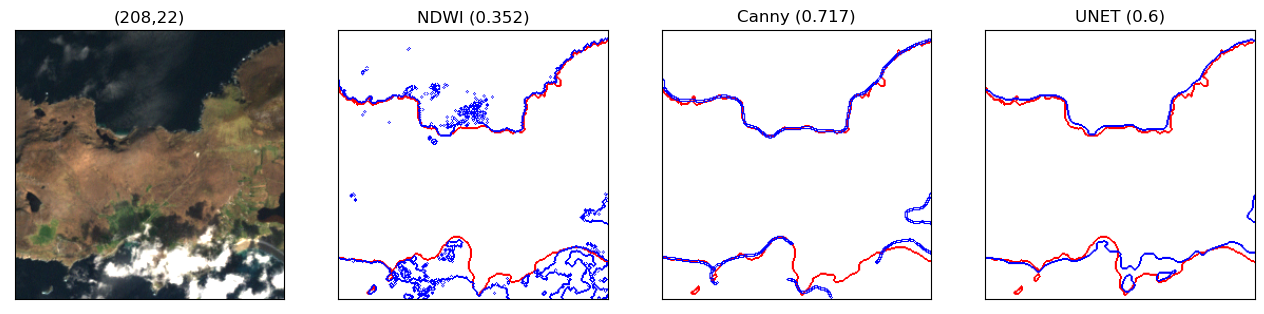

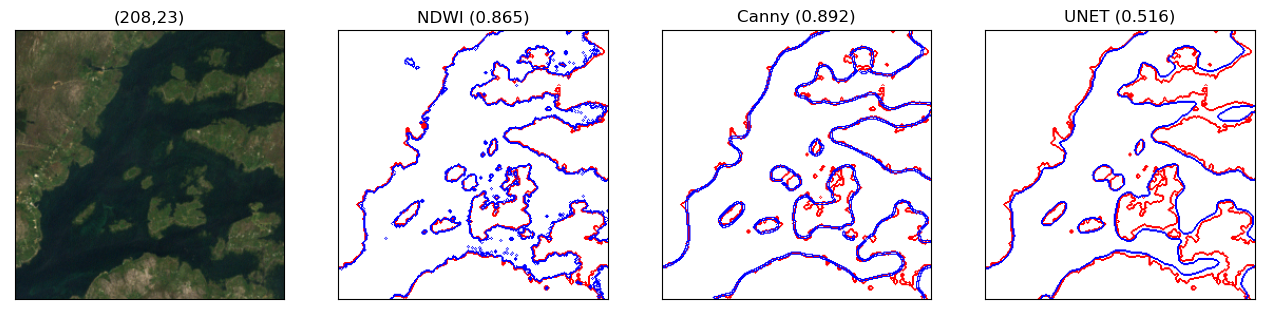

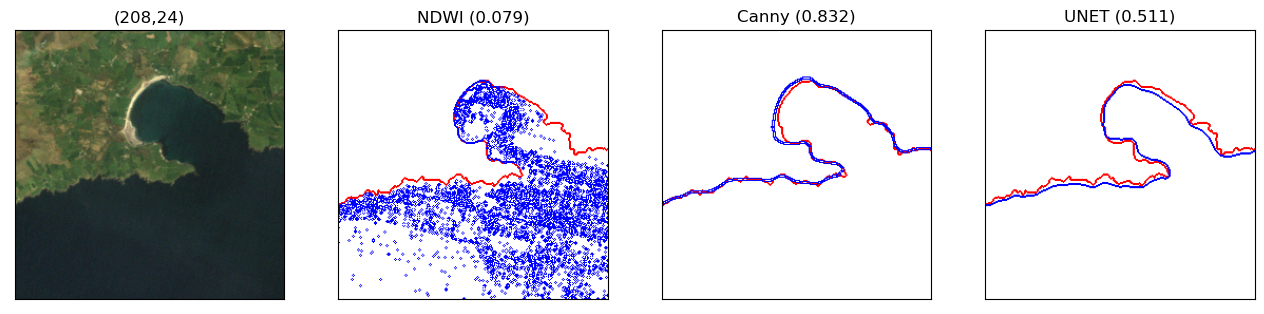

In [118]:
for id,tile in zip(chosen_ids, tiles):
    i = test_paths.index(test_path + id + '.npy')
    #plot_predicted_masks(i,methods = ['NDWI','XGBoost','UNET'])
    fig = plot_predicted_edge(i,methods = ['NDWI','Canny','UNET'],tile=tile)

    utils.save_fig(fig,f'{tile}_edge')
    


# Accuracy by year 

In [31]:
df_labels['decade'] = df_labels['year'].apply(lambda x: int(x/10)*10)

df_labels.head()

year altitude_category                                        id  path  \
0  2017              high  LC08_L2SP_205023_20170505_20200904_02_T1   205   
1  2019              high  LC08_L2SP_205023_20190628_20200827_02_T1   205   
2  2020              high  LC08_L2SP_205023_20200529_20200820_02_T1   205   
3  2015               low  LC08_L2SP_205024_20150124_20200910_02_T1   205   
4  2015              high  LC08_L2SP_205024_20150719_20200909_02_T1   205   

   row  satellite  cloud_cover  tier  utm_zone       lat      lon        date  \
0   23          8            2     1        30  53.10266 -5.02235  2017-05-05   
1   23          8            9     1        30  53.10258 -5.04996  2019-06-28   
2   23          8            2     1        30  53.10270 -5.03278  2020-05-29   
3   24          8            4     1        30  51.69320 -5.72348  2015-01-24   
4   24          8            5     1        30  51.69345 -5.70362  2015-07-19   

                         time  month   altitude    tile  decade  
0  2017-05-05 11:15:45.516137      5  51.383728  205_23    2010  
1  2019-06-28 11:16:20.726652      6  57.582579  205_23    2010  
2  2020-05-29 11:15:55.184734      5  56.487645  205_23    2020  
3  2015-01-24 11:16:47.907172      1  17.108840  205_24    2010  
4  2015-07-19 11:16:25.474865      7  56.077386  205_24    2010

In [32]:
df_labels.decade.value_counts()

1990    27
2000    24
2010    23
1980    15
2020    11
Name: decade, dtype: int64

In [35]:
decade_ids = get_grouped_ids(df_labels,cat='decade')

decades = [1980,1990,2000,2010,2020]
decade_acc = {}

preds_ndwi = final_preds['NDWI']
preds_unet = final_preds['UNET']

for decade in decades:
    ids = decade_ids[decade]
    idxs = [test_paths.index(test_path + id + '.npy') for id in ids]

    test_mask_alt = [test_mask[i] for i in idxs]
    preds_ndwi_alt = [preds_ndwi[i] for i in idxs]
    preds_unet_alt = [preds_unet[i] for i in idxs] 

    metrics_ndwi, arr_ndwi = eval.eval_metrics(test_mask_alt,preds_ndwi_alt)
    metrics_unet, arr_unet = eval.eval_metrics(test_mask_alt,preds_unet_alt)

    acc_ndwi = np.round(metrics_ndwi['accuracy'],3)
    acc_unet = np.round(metrics_unet['accuracy'],3)

    decade_acc[decade] = [acc_ndwi,acc_unet]
    
df_decade_acc = pd.DataFrame(decade_acc,index=['NDWI','UNET'])
df_decade_acc = df_decade_acc.T

df_decade_acc['n'] = [len(decade_ids[decade]) for decade in decades]
df_decade_acc[['n','NDWI','UNET']]

n   NDWI   UNET
1980  15  0.985  0.974
1990  27  0.961  0.965
2000  24  0.971  0.957
2010  23  0.969  0.974
2020  11  0.989  0.955

In [51]:
# count the number of tiles per decade
df = df_labels.copy()
df['tile'] = [f'({tile.split("_")[0]},{tile.split("_")[1]})' for tile in df['tile']]
df = df[['decade','tile']].groupby(['decade','tile']).size()
df.to_clipboard()
df.head()

decade  tile    
1980    (205,23)    1
        (205,24)    2
        (206,22)    1
        (206,23)    2
        (206,24)    1
dtype: int64

# Accuracy by altitude

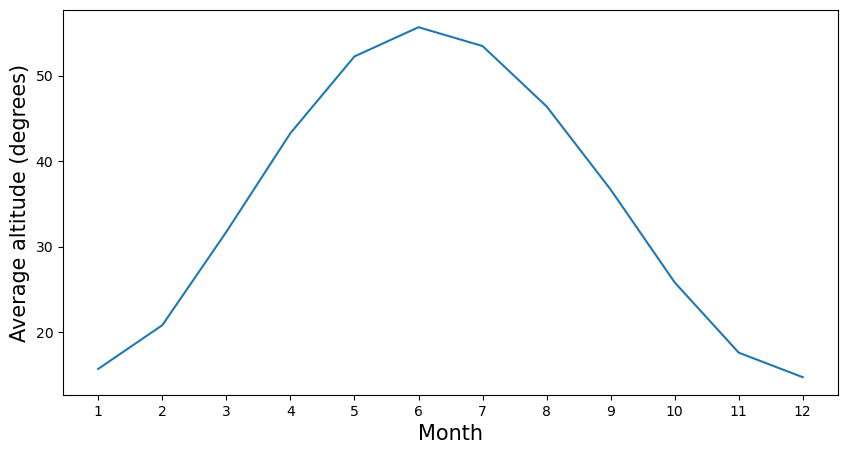

In [13]:
# altitude sense check
fig, ax = plt.subplots(1,1,figsize=(10, 5))

avg_altitude = df_scenes.groupby('month')['altitude'].mean()

# plot line chart of average altitude by month
sns.lineplot(data=avg_altitude, ax=ax)

# set ticks and labels
ax.set_xticks(range(1, 13))
ax.set_xlabel('Month',size=15)
ax.set_ylabel('Average altitude (degrees)',size=15)

utils.save_fig(fig,'Altitude')

In [216]:
altitude_ids = get_grouped_ids(df_labels,cat='altitude_category')

altitudes = ['low','medium','high']
altitude_acc = {}

preds_ndwi = final_preds['NDWI']
preds_unet = final_preds['UNET']

for altitude in altitudes:
    ids = altitude_ids[altitude]
    idxs = [test_paths.index(test_path + id + '.npy') for id in ids]

    test_mask_alt = [test_mask[i] for i in idxs]
    preds_ndwi_alt = [preds_ndwi[i] for i in idxs]
    preds_unet_alt = [preds_unet[i] for i in idxs] 

    metrics_ndwi, arr_ndwi = eval.eval_metrics(test_mask_alt,preds_ndwi_alt)
    metrics_unet, arr_unet = eval.eval_metrics(test_mask_alt,preds_unet_alt)

    acc_ndwi = np.round(metrics_ndwi['accuracy'],3)
    acc_unet = np.round(metrics_unet['accuracy'],3)

    altitude_acc[altitude] = [acc_ndwi,acc_unet]
    
df_altitude_acc = pd.DataFrame(altitude_acc,index=['NDWI','UNET'])
df_altitude_acc = df_altitude_acc.T

In [154]:
df_altitude_acc['n'] = [len(altitude_ids[altitude]) for altitude in altitudes]
df_altitude_acc[['n','NDWI','UNET']]

n   NDWI   UNET
low     34  0.984  0.968
medium  34  0.963  0.960
high    32  0.969  0.968

# Accuracy by tile 

In [24]:
tile_ids = get_grouped_ids(df_labels,cat='tile')

tiles = ['205_23','205_24','206_22','206_23','206_24','207_22','207_23','207_24','208_22','208_23','208_24']
tile_acc = {}

preds_ndwi = final_preds['NDWI']
preds_unet = final_preds['UNET']

for tile in tiles:
    ids = tile_ids[tile]
    idxs = [test_paths.index(test_path + id + '.npy') for id in ids]

    test_mask_tile = [test_mask[i] for i in idxs]
    preds_ndwi_tile = [preds_ndwi[i] for i in idxs]
    preds_unet_tile = [preds_unet[i] for i in idxs]

    metrics_ndwi, arr_ndwi = eval.eval_metrics(test_mask_tile,preds_ndwi_tile)
    metrics_unet, arr_unet = eval.eval_metrics(test_mask_tile,preds_unet_tile)

    acc_ndwi = np.round(metrics_ndwi['accuracy'],3)
    acc_unet = np.round(metrics_unet['accuracy'],3)

    tile_acc[tile] = [acc_ndwi,acc_unet]

df_tile_acc = pd.DataFrame(tile_acc,index=['NDWI','UNET'])
df_tile_acc = df_tile_acc.T

df_tile_acc['n'] = [len(tile_ids[tile]) for tile in tiles]

df_tile_acc.index = [f'({tile.split("_")[0]},{tile.split("_")[1]})' for tile in tiles]

df_tile_acc[['n','NDWI','UNET']]

n   NDWI   UNET
(205,23)  11  0.990  0.954
(205,24)  20  0.966  0.990
(206,22)   9  0.982  0.981
(206,23)   6  0.996  0.992
(206,24)  10  0.976  0.943
(207,22)   9  0.934  0.959
(207,23)  10  0.991  0.968
(207,24)   7  0.994  0.981
(208,22)   6  0.959  0.972
(208,23)   6  0.955  0.860
(208,24)   6  0.943  0.983

# Metrics without clouds 

0.056228956228956226


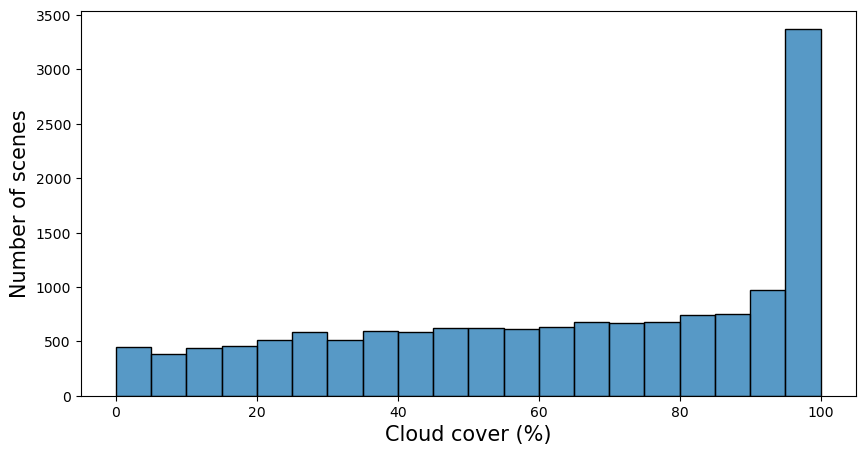

In [26]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))

# Histogram of cloud cover
sns.histplot(data=df_scenes, x='cloud_cover', bins=20)
plt.xlabel('Cloud cover (%)', fontsize=15)
plt.ylabel('Number of scenes', fontsize=15)

# Percentage of cloud cover below 10%
print(len(df_scenes[df_scenes['cloud_cover'] < 10]) / len(df_scenes))

utils.save_fig(fig, 'cloud_cover_hist')


94


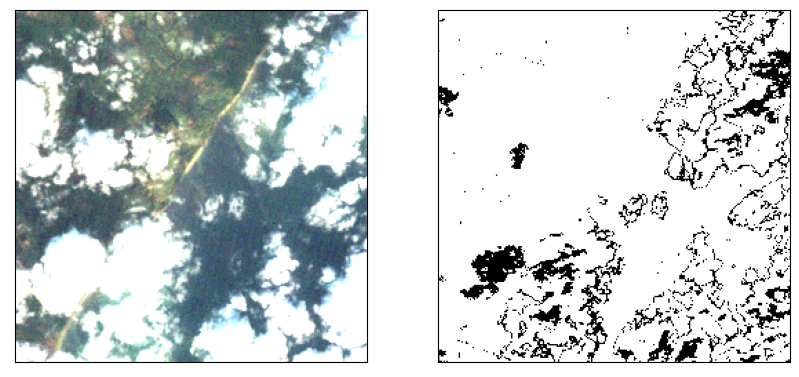

In [69]:
def plot_cloud_mask(i):

    fig,ax = plt.subplots(1,2,figsize=(10,5))
    
    path = test_paths[i]
    test = np.load(path)

    rgb = utils.rgb_from_stack(test)
    ax[0].imshow(rgb)

    rgb = rgb*test_cloud_mask[i][:,:,np.newaxis]

    ax[1].imshow(test_cloud_mask[i],cmap='gray')

    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
   
i = np.random.randint(0,len(test_paths))
print(i)
plot_cloud_mask(i)

In [95]:
# Evaluation metrics with cloud free pixels
df_cloud_metrics = round(df_cloud_metrics,3)
df_cloud_metrics.columns = ['Method','Accuracy','Balanced Accuracy','Precision','Recall','F1','MSE','FOM']
incl = ['Method','Accuracy','Precision','Recall','F1']
df_cloud_metrics[incl].to_clipboard(index=False)
df_cloud_metrics[incl].head(6)

Method  Accuracy  Precision  Recall     F1
0     NDWI     0.978      0.994   0.958  0.974
1    Canny     0.000      0.000   0.000  0.000
2  XGBoost     0.930      0.949   0.882  0.900
3     UNET     0.967      0.967   0.961  0.961
4  ATTUNET     0.965      0.945   0.974  0.958
5   R2UNET     0.908      0.905   0.913  0.901

# Archive

In [6]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from PIL import Image
from osgeo import gdal

import os
import glob
import random
import torch

class model_eval:

    def __init__(self, model, images,targets, preds):
        self.model = model
        self.images = images
        self.targets = targets
        self.preds = preds
        self.fig_path = '/Users/conorosullivan/Google Drive/My Drive/UCD/research/Interpreting UNet/Figures/{}.png'
        self.device = torch.device('mps') 

    def calc_accuracy(self,pred, target):
        """Returns accuracy of model prediction"""
        
        correct = np.sum(target == pred)
        h,w = target.shape

        accuracy = correct/(h*w)
            
        return correct, accuracy
    
    def get_rgb(self,i):
        """Return normalized RGB channels from sentinal image"""
        img = self.images[i].cpu().detach().numpy()
        img = img.transpose(1,2,0)
        rgb = img[:,:,[2,1,0]]
        rgb = np.clip(rgb,0,0.2)/0.2

        return rgb

    def plot_pred(self,i,save=None):
        """Diplays RGB image, label and prediction with accuracy"""
        rgb = self.get_rgb(i)
        target = self.targets[i]
        pred = self.preds[i]

        fig,axs = plt.subplots(1,3,figsize=(15,15))
        fig.patch.set_facecolor('xkcd:white')

        axs[0].imshow(rgb)
        axs[0].set_title("RGB Image",size=15)

        axs[1].imshow(target,cmap="gray")
        axs[1].set_title("Target",size=15)

        axs[2].imshow(pred,cmap="gray")
        correct, accuracy = self.calc_accuracy(pred, target)
        accuracy = round(accuracy*100, 2)
        axs[2].set_title("Accuracy: {}%".format(accuracy))

        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])

        if save:
            plt.savefig(self.fig_path.format(save),bbox_inches='tight',dpi=300)

    
    def confusion_metrics(self,pred,target):
        """Returns confusion matrix metrics"""
        
        TP = np.sum((pred == 1) & (target == 1))
        TN = np.sum((pred == 0) & (target == 0))
        FP = np.sum((pred == 1) & (target == 0))
        FN = np.sum((pred == 0) & (target == 1))
        
        return TP,TN,FP,FN
    
    def eval_metrics(self):
        """Evaluate model performance on test set"""

        TP,TN,FP,FN =0,0,0,0
        r_accuracy = []
        r_balanced_accuracy = []
        r_precision = []
        r_recall = []
        r_f1 = []

        # Calcualte accuracy
        for i in range(len(self.targets)):
            target = self.targets[i]
            pred = self.preds[i]

            TP_,TN_,FP_,FN_ = self.confusion_metrics(pred,target)
            TP += TP_
            TN += TN_
            FP += FP_
            FN += FN_

            r_accuracy.append((TP_+TN_)/(TP_+TN_+FP_+FN_))
            r_balanced_accuracy.append(0.5*(TP_/(TP_+FN_) + TN_/(TN_+FP_)))
            r_precision.append(TP_/(TP_+FP_))
            r_recall.append(TP_/(TP_+FN_))
            r_f1.append(2*(r_precision[-1]*r_recall[-1])/(r_precision[-1]+r_recall[-1]))

        accuracy = (TP+TN)/(TP+TN+FP+FN)
        balanced_accuracy = 0.5*(TP/(TP+FN) + TN/(TN+FP))
        precision = TP/(TP+FP)
        recall = TP/(TP+FN)
        f1 = 2*(precision*recall)/(precision+recall)

        return {'accuracy':r_accuracy,
                'balanced_accuracy':r_balanced_accuracy,
                'precision':r_precision,
                'recall':r_recall,
                'f1':r_f1},{'accuracy':accuracy,
                'balanced_accuracy':balanced_accuracy,
                'precision':precision,
                'recall':recall,
                'f1':f1}
    
    def plot_importance(self,importance,channels_,label=None,save=None):
        
        fig, ax  = plt.subplots(figsize=(10,4))
        fig.set_facecolor('white')


        plt.bar(height=importance,x=np.arange(0,len(channels_)),)

        plt.ylabel(label,size=20)

        ax.set_xticks(np.arange(0,len(channels_)),channels_,rotation=90, size=15)
        ax.set_yscale('log')

        plt.yticks(size=15)

        if save:
            plt.savefig(self.fig_path.format(save),bbox_inches='tight',facecolor='white', dpi=300)

    def get_weights(self):
        """Returns average weight of input layer"""

        weight = self.model.e1.conv.conv1.weight
        weight = weight.detach().cpu().numpy()
        weight = np.abs(weight)
        avg_weight = weight.transpose(1,0,2,3).mean(axis=(1,2,3))
    
        return avg_weight
    
    def shuffle_band(self,band):
        """Shuffle a single spectral band of an image"""

        perm_image = band.ravel()
        random.shuffle(perm_image)
        perm_image.resize(256,256)

        return perm_image

    def permutate_bands(self,img,bands):
        """Permuate bands in list of bands"""

        img = img.copy()

        band_dict = {'Blue':0,'Green':1,'Red':2,'NIR':3,'SWIR 1':4,'SWIR 2':5,'thermal':6}


        bands_i = [band_dict[b] for b in bands]

        for i in bands_i:
            img[i,:,:] = self.shuffle_band(img[i,:,:])

        return img
    
    def get_pred(self,output):
        """Get prediction from model output"""

        pred = output.cpu().detach().numpy()[1]
        pred = np.round(pred)

        return pred

    def get_perm_accuracy(self,bands):
        """Get accuracy of model on permuated spectral bands"""

        orignal_images = self.images.cpu().detach().numpy()

        perm_images = orignal_images.copy()

        for i in range(len(orignal_images)):
            perm_images[i] = self.permutate_bands(perm_images[i],bands)
                

        perm_images = np.array(perm_images)
        perm_images = torch.from_numpy(perm_images)
        perm_images = perm_images.to(self.device)

        # get model predcitions
        output = self.model(perm_images)
        perm_preds = np.array([self.get_pred(x) for x in output])
        
        # Calc accuracy
        r_targets = np.array(self.targets)
        x,y,z = np.shape(r_targets)
        accuracy = np.sum(r_targets == perm_preds)/(x*y*z)

        return accuracy

In [2]:
# Set device
device = torch.device('mps')  #UPDATE
print("Using device: {}\n".format(device))

# Load saved model 
model = torch.load('../models/LANDSAT-UNET-19JUL23.pth', map_location=torch.device('cpu') )
model.eval()
model.to(device)

Using device: mps



U_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )

In [3]:
# Load dataset
def get_loader(paths,batch_size=False):

    test_data = TrainDataset(paths,-2)
    if batch_size:
        test_loader = DataLoader(test_data, batch_size=batch_size)
        print(batch_size)
    else:
        test_loader = DataLoader(test_data, batch_size=test_data.__len__())

    print(test_data.__len__())
    return test_loader
paths = glob.glob("../data/test/*.npy")
test_loader = get_loader(paths,10)

10
100


In [4]:
def get_preds(loader):
    images, target = next(iter(loader))
    images = images.to(device)

    # Get model output
    output = model(images)
    sm = nn.Softmax(dim=1)
    output = sm(output)
    print(output.shape)
    # Get model predictions 
    targets = [np.array(t[1]) for t in target] 


    preds = [np.round(out) for out in output.cpu().detach()]
    preds = [np.array(pred[1]) for pred in preds]

    return images, targets, preds

images, targets, preds = get_preds(test_loader)

torch.Size([10, 2, 256, 256])


In [7]:
# Initialize data processor
eval = model_eval(model,images,targets,preds)

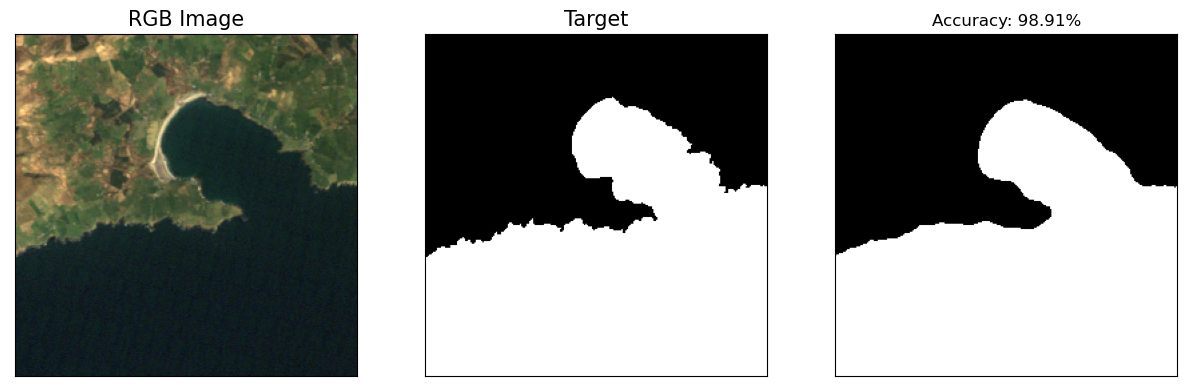

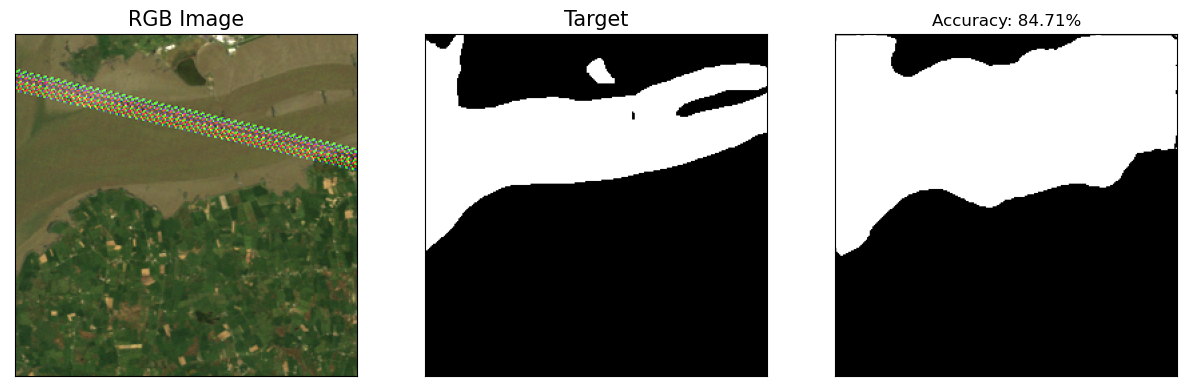

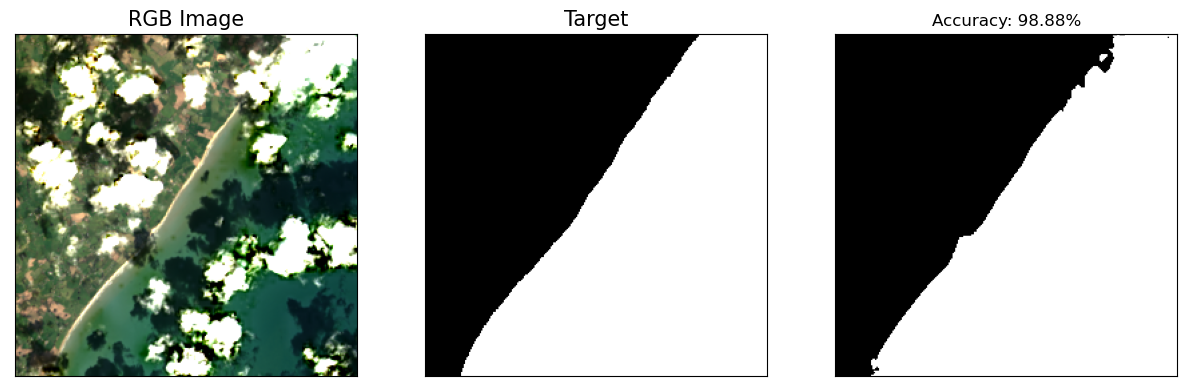

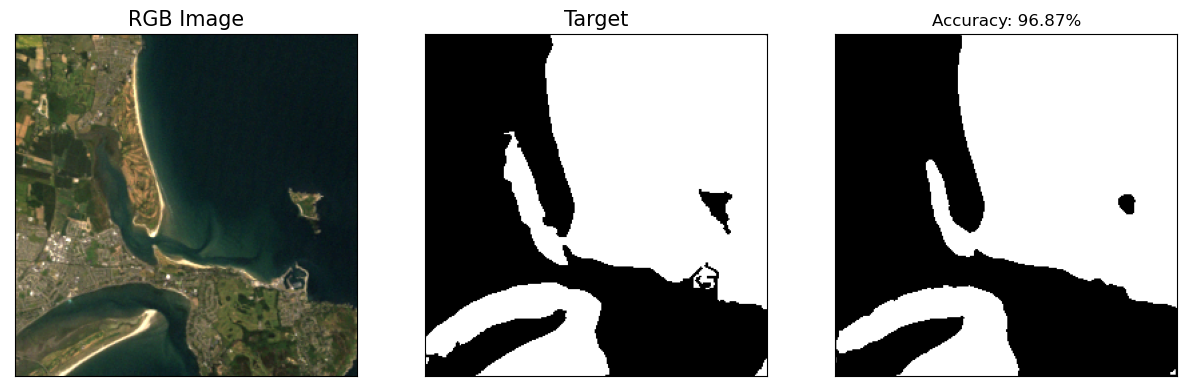

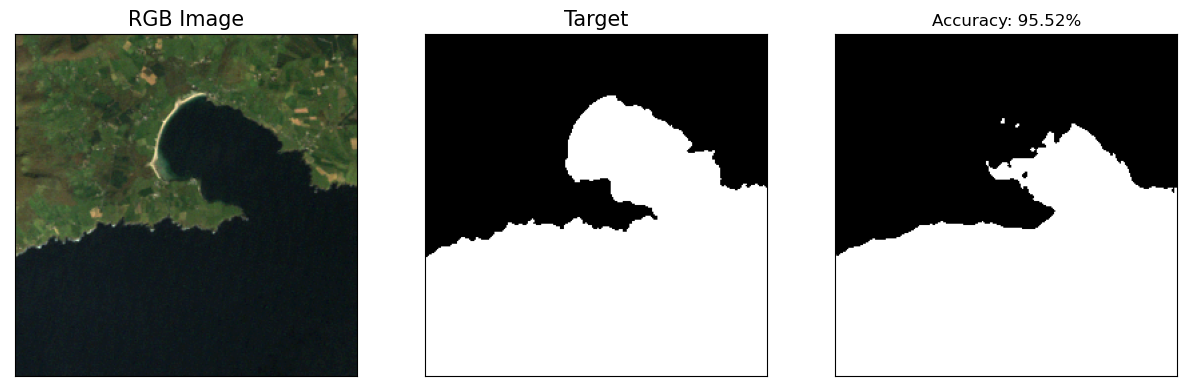

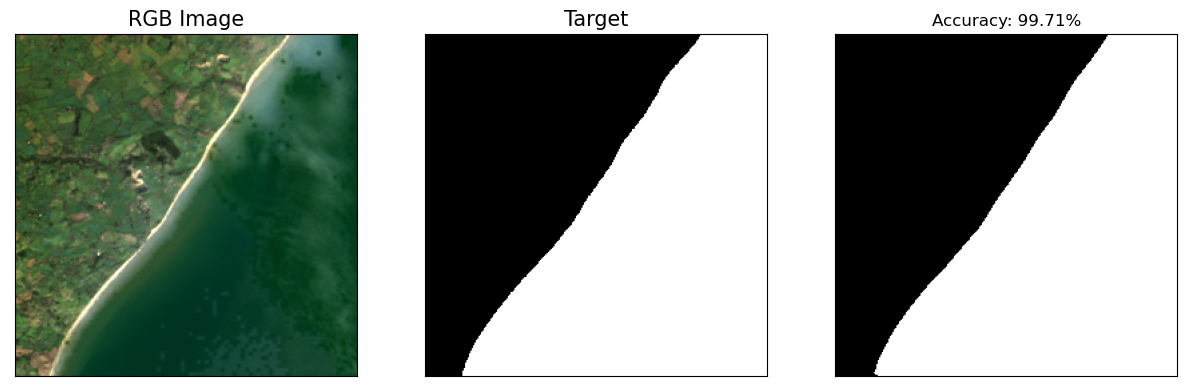

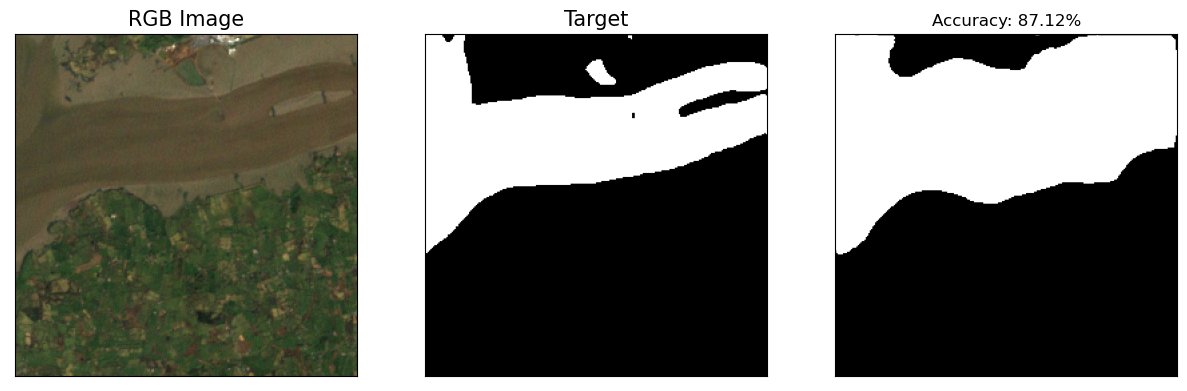

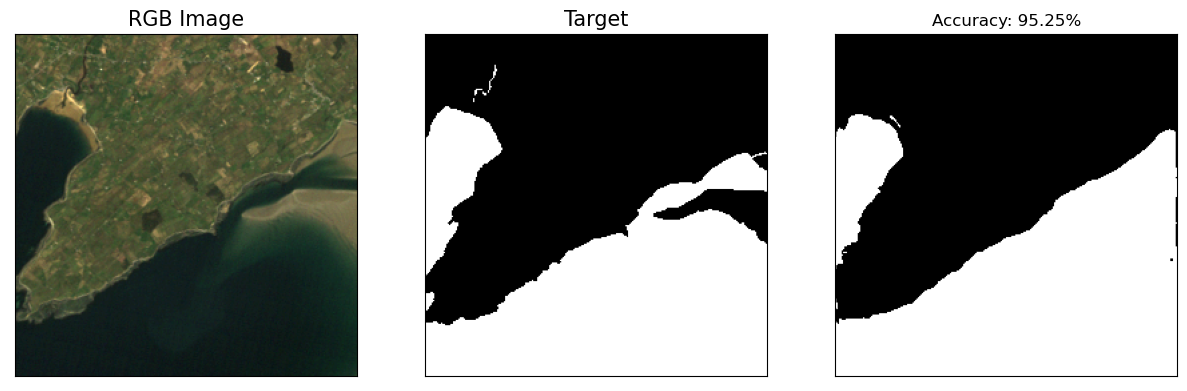

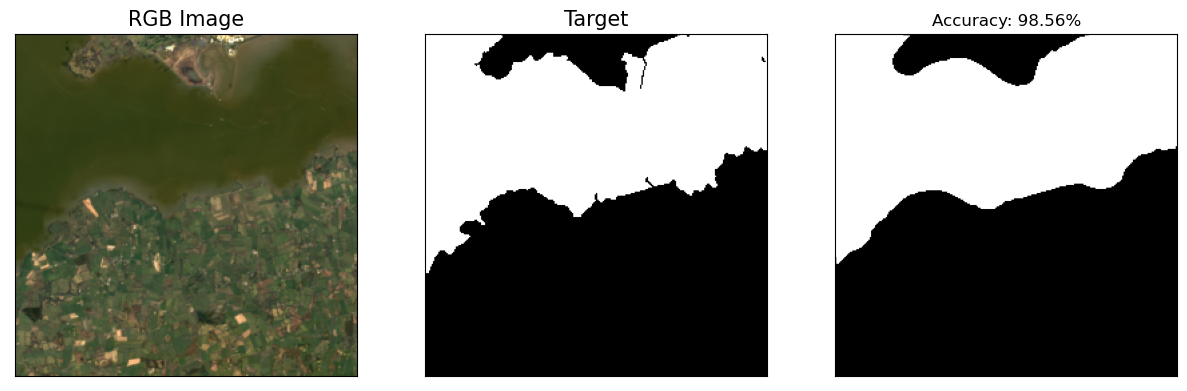

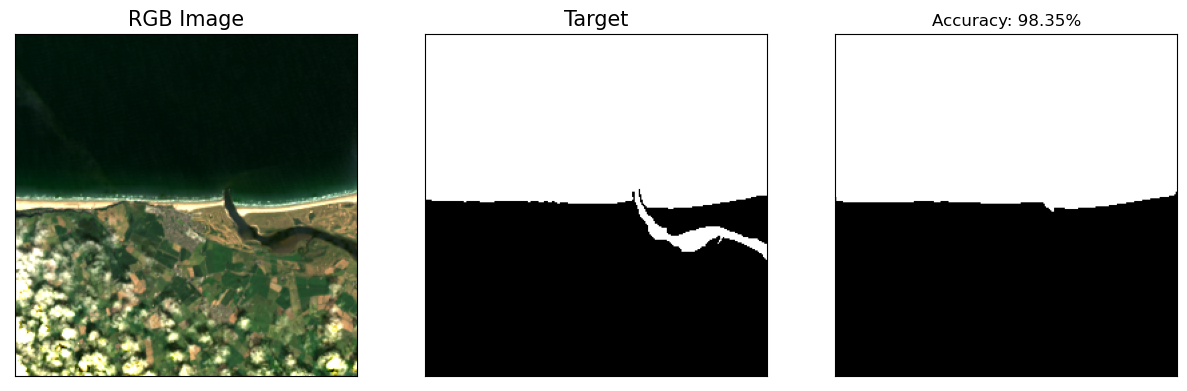

In [8]:
for i in range(10):
    eval.plot_pred(i)

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_3238/1904126001.py:105: RuntimeWarning: invalid value encountered in long_scalars
  r_balanced_accuracy.append(0.5*(TP_/(TP_+FN_) + TN_/(TN_+FP_)))
/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_3238/1904126001.py:106: RuntimeWarning: invalid value encountered in long_scalars
  r_precision.append(TP_/(TP_+FP_))
/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_3238/1904126001.py:107: RuntimeWarning: invalid value encountered in long_scalars
  r_recall.append(TP_/(TP_+FN_))


Average Metrics
accuracy: 0.9647624206542968
balanced_accuracy: nan
precision: nan
recall: nan
f1: nan
Metrics
accuracy: 0.9647624206542968
balanced_accuracy: 0.9635327235197196
precision: 0.9684484908590548
recall: 0.952072109768642
f1: 0.9601904791784931


(array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

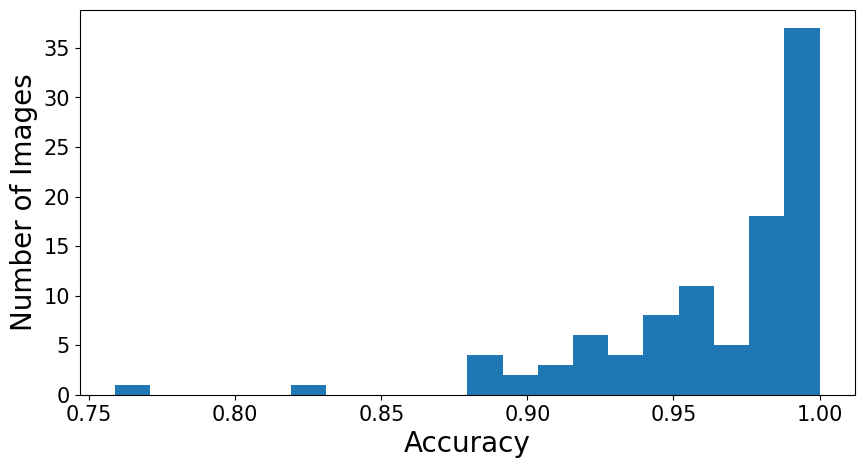

In [12]:
r_metrics, metrics = eval.eval_metrics()
accuracy = r_metrics['accuracy']

print("Average Metrics\n=================")
for m in ['accuracy','balanced_accuracy','precision','recall','f1']:
    print("{}: {}".format(m,np.mean(r_metrics[m])))

print("Metrics\n=================")
for m in ['accuracy','balanced_accuracy','precision','recall','f1']:
    print("{}: {}".format(m,metrics[m]))


# Plot accuracy
plt.figure(figsize=(10,5))

plt.hist(accuracy, bins=20)
plt.xlabel("Accuracy",size=20)
plt.ylabel("Number of Images",size=20)
plt.xticks(size=15)
plt.yticks(size=15)

In [31]:
band_dict = {'Blue':0,'Green':1,'Red':2,'NIR':3,'SWIR 1':4,'SWIR 2':5,'thermal':6}

oringal_bands = ['Blue','Green','Red','NIR','SWIR 1','SWIR 2','thermal']

perm_bands = []
for band in oringal_bands:
    perm_bands.append([band])

# Calculate permutation importance
n = 5
rows = []

accuracy = eval.get_perm_accuracy([])
rows.append([str([]),0,accuracy])

for bands in perm_bands:
    print(bands,end=" ")
    for i in range(n):
        accuracy = eval.get_perm_accuracy(bands)
        row = [str(bands),i,accuracy] 
        rows.append(row)

        print(i,end=" ")

    print()
    
df_metrics = pd.DataFrame(rows,columns = ['Bands',"Perm","Accuracy"])
df_metrics.to_csv(base_path+ 'perm_metrics_17JUN23.csv',index=False)
df_metrics.head()

['Blue'] 0 1 2 3 4 
['Green'] 0 1 2 3 4 
['Red'] 0 1 2 3 4 
['NIR'] 0 1 2 3 4 
['SWIR 1'] 0 1 2 3 4 
['SWIR 2'] 0 1 2 3 4 
['thermal'] 0 1 2 3 4 


Bands  Perm  Accuracy
0        []     0  0.964762
1  ['Blue']     0  0.965356
2  ['Blue']     1  0.965328
3  ['Blue']     2  0.965345
4  ['Blue']     3  0.965312

Blue -0.06
Green 0.07
Red -0.1
NIR 24.37
SWIR 1 1.39
SWIR 2 -0.11
thermal 0.03


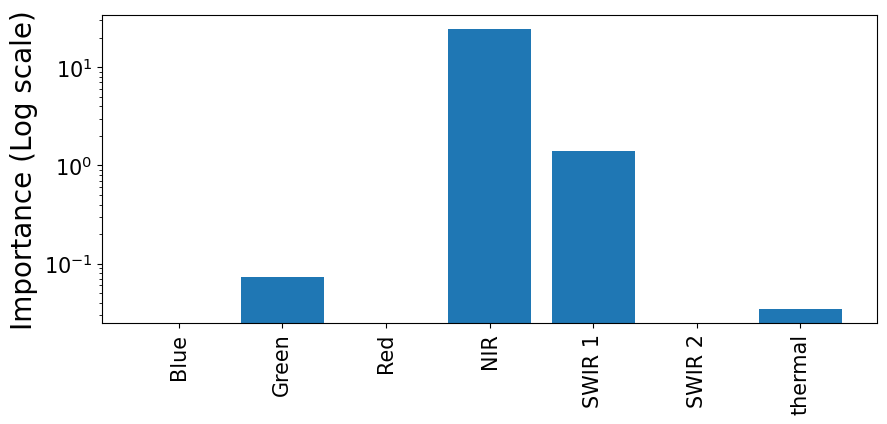

In [33]:
# Plot permutation importance for individual bands
df_metrics = pd.read_csv(base_path+ 'perm_metrics_17JUN23.csv')
mean = df_metrics[['Bands','Accuracy']].groupby(["Bands"], sort=False ).mean().reset_index()

orginal_accuracy = mean['Accuracy'].values[0]
bands = mean['Accuracy'].values[1:8]
importance = [(orginal_accuracy-b)*100 for b in bands]

for i,imp in enumerate(importance):
    print(oringal_bands[i],np.round(imp,2))

eval.plot_importance(importance,oringal_bands,label="Importance (Log scale)")